### Pontifícia Universidade Católica do Rio de Janeiro
### Álgebra Linear Para Data Science e Machine Learning - P2
#### **Nome**: Alysson Gomes
#### **Matrícula**: 1812766

In [49]:
import math
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import * #funções de similaridade
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import euclidean
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize, LabelBinarizer
from tqdm import tqdm

### Building Graph

Estratégias de construção do grafo:
* k-nearest neighbor
* ε-neighborhood
* fully connected

In [3]:
def k_nearest_neighbor(matrix, k):
    """
        Parameters:
            matrix_similarity: matriz de similaridade ou de distâncias calculada externamente
            k: quantidade de vizinhos de cada vértice
        Return:
            W: matriz de adjacência cujos os valores correspondem a similaridade
            D: matriz de graus cujos os valores é soma das similaridade
    """
    W = np.zeros(matrix.shape)
    D = np.zeros(matrix.shape)
#     print(matrix.shape)
    """
    type_: distingue entre matriz de distância e matriz de similaridade
        1 = distância
        2 = similaridade
    """
    type_ = 1
    if matrix[0][0] == 1:
        type_ = 2
#     print(type_)
    #Impede que cada vetor se ligue a ele mesmo
    for i in range(matrix.shape[0]):
        if type_ == 1:
            matrix[i][i] = math.inf
        if type_ == 2:
            matrix[i][i] = 0
    
    # W matrix
    for i in range(W.shape[0]):
        k_mod = k
        for r in W[i]:
            if r != 0:
                k_mod -= 1

        for j in range(k_mod):
            number = None
            if type_ == 1:
                number = math.inf
            if type_ == 2:
                number = 0
            index_number = None

            for l in range(W.shape[0]):
                if type_ == 1: #matriz de distâncias
                    if matrix[i][l] < number:
                        number = matrix[i][l]
                        index_number = l
                if type_ == 2: #matriz de similaridade
                    if matrix[i][l] > number:
                        number = matrix[i][l]
                        index_number = l
            try:
                if type_ == 1:
                    W[i][index_number],W[index_number][i] = 1-number, 1-number
                    matrix[i][index_number], matrix[index_number][i] = math.inf, math.inf
                if type_ == 2:
                    W[i][index_number],W[index_number][i] = number, number
                    matrix[i][index_number], matrix[index_number][i] = 0, 0
            except Exception as e:
                print(i)
                print(index_number)

    #D matrix
    for i in range(matrix.shape[0]):
        qt = 0
        for j in range(matrix.shape[0]):
            if W[i][j] > 0:
                qt += W[i][j]
        D[i][i] = qt
    return W,D

def eps_neighborhood(matrix, eps):
    """
        Parameters:
            matrix_similarity: matriz de similaridade ou de distâncias calculada externamente
            eps: parâmetro de distância epson
        Return:
            W: matriz de adjacência cujos os valores correspondem a similaridade
            D: matriz de graus cujos os valores é soma das similaridade
    """
    W = np.zeros(matrix.shape)
    D = np.zeros(matrix.shape)
    
    """
    type_: distingue entre matriz de distância e matriz de similaridade
        1 = distância
        2 = similaridade
    """
    type_ = 1
    if matrix[0][0] == 1:
        type_ = 2
    
    #Impede que cada vetor se ligue a ele mesmo
    for i in range(matrix.shape[0]):
        if type_ == 1:
            matrix[i][i] = math.inf
        if type_ == 2:
            matrix[i][i] = 0
    
    # W matrix
    for i in range(W.shape[0]):
        for l in range(i+1):
            if type_ == 1: #matriz de distâncias
                if matrix[i][l] <= eps:
                    W[i][l],W[l][i] = 1-matrix[i][l], 1-matrix[i][l]
            if type_ == 2: # matriz de similaridade
                if 1-matrix[i][l] <= eps: 
                    W[i][l],W[l][i] = matrix[i][l], matrix[i][l]
            
    #D matrix
    for i in range(matrix.shape[0]):
        qt = 0
        for j in range(matrix.shape[0]):
            if W[i][j] > 0:
                qt += W[i][j]
        D[i][i] = qt
    return W,D

def fully_connected(matrix, _):
    """
        Parameters:
            matrix: matriz de similaridade ou de distâncias calculada externamente
        Return:
            W: matriz de adjacência cujos os valores correspondem a similaridade
            D: matriz de graus cujos os valores é soma das similaridade
    """
    W = np.zeros(matrix.shape)
    D = np.zeros(matrix.shape)
    
    """
    type_: distingue entre matriz de distância e matriz de similaridade
        1 = distância
        2 = similaridade
    """
    type_ = 1
    if matrix[0][0] == 1:
        type_ = 2
    
    # W matrix
    for i in range(W.shape[0]):
        for l in range(W.shape[1]):
            if type_ == 2: #matriz de similaridade
                if matrix[i][l] > 0:
                    W[i][l],W[l][i] = matrix[i][l], matrix[i][l]
            else: #matriz de distâncias
                if 1-matrix[i][l] > 0:
                    W[i][l],W[l][i] = 1-matrix[i][l], 1-matrix[i][l]

    #D matrix
    for i in range(matrix.shape[0]):
        qt = 0
        for j in range(matrix.shape[0]):
            if W[i][j] > 0:
                qt += W[i][j]
        D[i][i] = qt
    return W,D

### Spectral Clustering
* Unnormalized spectral clustering
* Normalized spectral clustering to Shi e Malik
* Normalized spectral clustering to Ng, Jordan, and Weiss

Todos seguem os seguinte padrão:
* **Parâmetros**:
    * matrix_similarity: matriz de similaridade ou de distâncias calculada externamente
    * k: quantidade de clusters
    * build_graph: método de construção do graph de similaridade
    * param_graph: parâmetros para o métedo build_graph
* **Retorno**:
    * pred: lista com o id do cluster de cada data point

In [4]:
#Unnormalized Spectral Clustering
def unnormalized_spectral_clustering(matrix_similarity, k, build_graph, param_graph):
    # construindo a matriz de adjacencia a partir matriz de similaridade
    W,D = build_graph(matrix_similarity, param_graph) 
    #construindo matriz Laplaciana não normalizada
    L = D - W 
    #calculando os autovetores
    _, eigenvectors = linalg.eigh(L) 
    #gerando a matriz U com os k primeiros autovetores associados aos k primeiros autovalores
    U = eigenvectors[:,0:k]
    #clusterizando com o k-means
    pred = KMeans(n_clusters=k, max_iter=100).fit_predict(U) 
    return pred

#Normalized Spectral Clustering to Shi and Malik
def normalized_spectral_clustering_shi_malik(matrix_similarity, k, build_graph, param_graph):
    # construindo a matriz de adjacencia a partir matriz de similaridade
    W,D = build_graph(matrix_similarity, param_graph)
    #construindo matriz Laplaciana não normalizada
    L = D - W
    
    #testando se a matriz D é definida positiva
    if np.all(linalg.eigvals(D) > 0) == False:
        print("A matriz D não é definida positiva")
        return np.array([])
    #calculando os autovetores generalizados
    _, eigenvectors = linalg.eigh(L, b=D) 
    #gerando a matriz U com os k primeiros autovetores associados aos k primeiros autovalores
    U = eigenvectors[:,0:k]
    #clusterizando com o k-means
    pred = KMeans(n_clusters=k, max_iter=100).fit_predict(U)   
    return pred

#Normalized Spectral clustering to Ng, Jordan, and Weiss
def normalized_spectral_clustering_ng_jordan_weiss(matrix_similarity, k, build_graph, param_graph):
    # construindo a matriz de adjacencia a partir matriz de similaridade
    W,D = build_graph(matrix_similarity, param_graph)
    #construindo matriz Laplaciana não normalizada
    L = D - W
    #calculando D^(-1/2)
    for i in range(D.shape[0]):
        D[i][i] = 1/math.sqrt(D[i][i])
    
    #construindo matriz Laplaciana normalizada
    L_sym = np.dot(np.dot(D, L), D)
    #calculando os autovetores
    _, eigenvectors = linalg.eigh(L_sym)
    #gerando a matriz U com os k primeiros autovetores associados aos k primeiros autovalores
    U = eigenvectors[:,0:k]
    
    #gerando a matriz T a partir da normalização de U
    T = np.zeros(U.shape)
    for i in range(U.shape[0]):
        n = math.sqrt(sum(list(map(lambda x: x**2,U[i]))))
        for j in range(U.shape[1]):
            T[i][j] = U[i][j]/n
    
    #clusterizando com k-means
    pred = KMeans(n_clusters=k).fit_predict(T)   
    return pred

#### Ploting Dataset

In [5]:
def plot(values,x,y):
    v = 0
    for i in range(x):
        for j in range(y):
            plt.subplot(x,y,v+1)
            plt.scatter(values[v]['x'], values[v]['y'], c=values[v]['c'],cmap='viridis')
            plt.title(values[v]['title'])
            plt.grid(True)
            fig_size = plt.rcParams["figure.figsize"]
            fig_size = (20,14)
            plt.rcParams["figure.figsize"] = fig_size
            v += 1
    return plt.show()

#### Matriz de Similaridade Euclidiana

In [6]:
def similarity_pair(x, y):
    return 1/float(1 + euclidean(x,y))

def euclidean_similarity(matrix_points):
    n = len(matrix_points)
    S = np.zeros((n,n)) #distance matrix
    
    with tqdm(total=n, desc='euclidean_similarity - building matrix') as pbar:
        for i in range(n):
            for j in range(i,n):
                a = similarity_pair(matrix_points[i], matrix_points[j])
                S[i][j] = a
                S[j][i] = S[i][j]
            pbar.update(1)
    return S

## Testes

Os dois primeiros datasets são formados por dados gerados sinteticamente, usados para avaliar a corretude do algoritmos. Utilizamos o módulo `adjusted_rand_score`, disponível no pacote de métricas para clusterização do scikit-learn, para avaliar numéricamente a qualidade da clusterização.

Pelos testes mostrados abaixo, podemos ver que, com exceção dos algoritmos que utilizaram a estratégia `fully connected` para construir o grafo, todos alcançaram resultados satisfatórios.

#### Dataset de Ponto  D31 - **Benchmark**

O dataset foi desenvolvido por Veenman, Reinders e Backer (2002).

**Disponível em: **[http://cs.joensuu.fi/sipu/datasets/D31.txt](http://cs.joensuu.fi/sipu/datasets/D31.txt)

In [8]:
X = pd.read_csv('D31/D31.data',sep=' ')
Y = pd.read_csv('D31/D31.labels', sep=' ')

x = np.matrix(X)[:,0]
x = list(map(lambda v: v[0], x.tolist()))
y = np.matrix(X)[:,1]
y = list(map(lambda v: v[0], y.tolist()))

euclidean_similarity - building matrix: 100%|██████████| 3100/3100 [02:11<00:00, 23.53it/s] 


unnormalized with knn = 0.9503214872841527
unnormalized with eps = 0.8404350452695032
unnormalized with fully = 0.1312963126186595
shi and malik with knn = 0.9503214872841527
shi and malik with eps = 0.9541718917510653
shi and malik with fully = 0.9465167769814353
ng, jordan and weiss with knn = 0.949658637483568
ng, jordan and weiss with eps = 0.9535924822809996
ng, jordan and weiss with fully = 0.9496775260783525


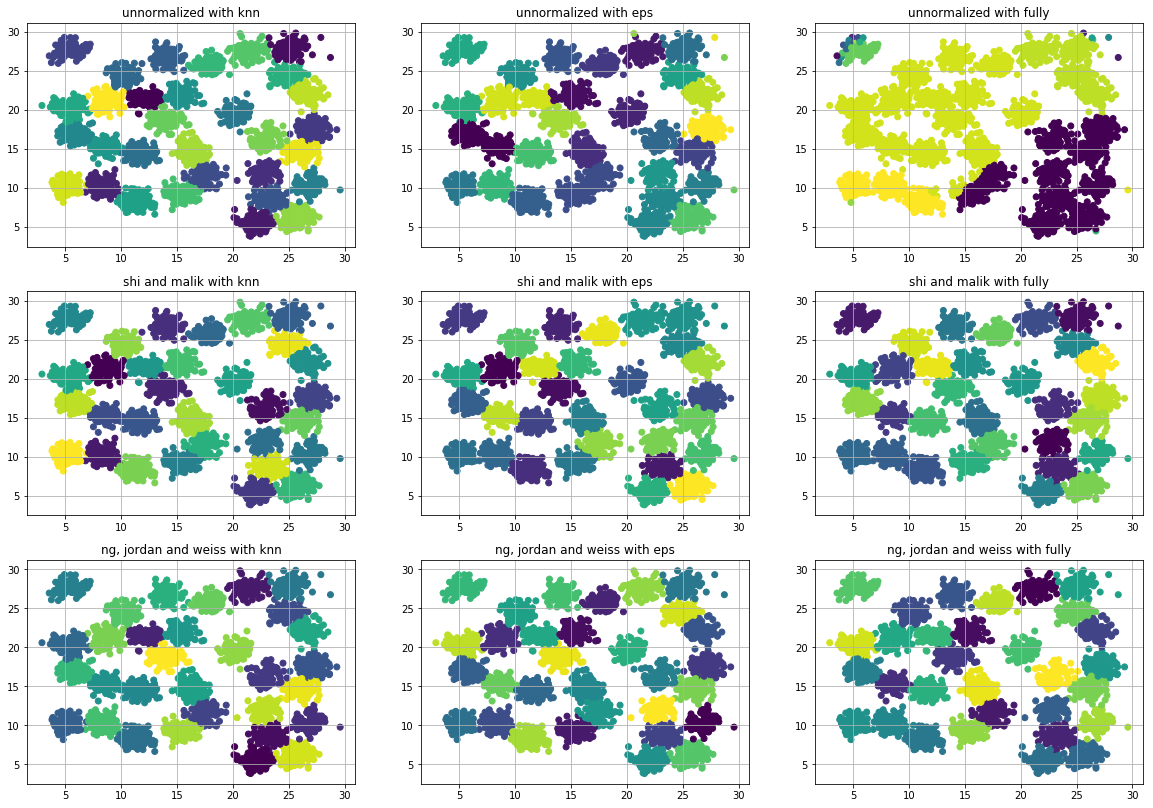

In [101]:
k = 31
eps = 0.65
k_nn = 100

results = []
experiments = [
    {'title':'unnormalized with knn','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'unnormalized with eps','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'unnormalized with fully','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'shi and malik with knn','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'shi and malik with eps','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'shi and malik with fully','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'ng, jordan and weiss with knn','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'ng, jordan and weiss with eps','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'ng, jordan and weiss with fully','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None}
]

matrix_similarity = euclidean_similarity(X.values)
for e in experiments:
    matrix_similarity_copy = matrix_similarity.copy()
    clusters = e['clusterization'](matrix_similarity_copy, e['k'], e['build_graph'], e['parameter_graph'])
    #avaliação númerica do resultado
    print(e['title']+" = "+str(adjusted_rand_score(Y['y'].tolist(),clusters.tolist())))
    results.append({'x':x, 'y':y, 'c':clusters.tolist(), 'title': e['title']}),

#avaliação vizual do resultado
plot(results,3,3)

#### Gabarito

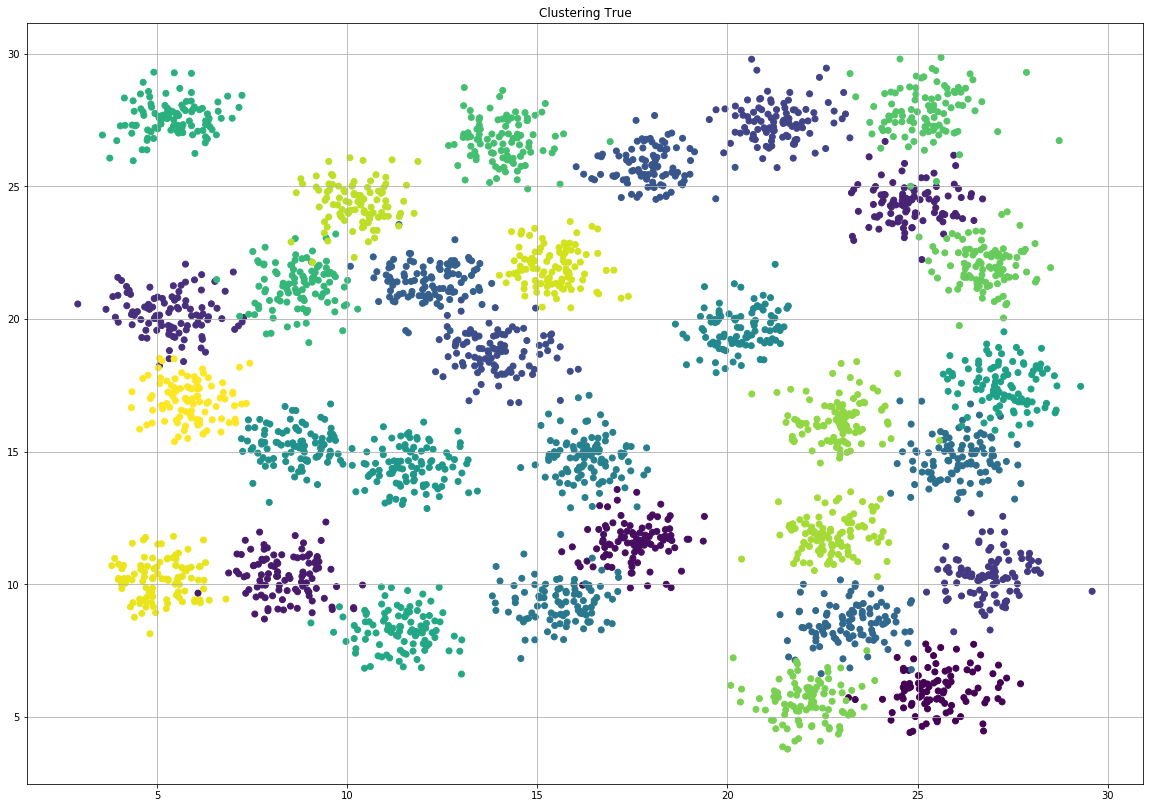

In [102]:
result_true = [
    {'x':x, 'y':y, 'c':Y['y'].tolist(), 'title':'Clustering True'}
]
plot(result_true,1,1)

-------------

#### Dataset de Pontos Aggregation - **Benchmark**

O dataset foi desenvolvido por Gionis, Mannila e Tsaparas (2007)

**Disponível em:** [http://cs.joensuu.fi/sipu/datasets/Aggregation.txt](http://cs.joensuu.fi/sipu/datasets/Aggregation.txt)

In [112]:
X = pd.read_csv('aggregation/aggregation.csv',sep='\t')
Y = X['cluster']

x = np.matrix(X)[:,0]
x = list(map(lambda v: v[0], x.tolist()))
y = np.matrix(X)[:,1]
y = list(map(lambda v: v[0], y.tolist()))

euclidean_similarity - building matrix: 100%|██████████| 788/788 [00:08<00:00, 87.73it/s] 


unnormalized with knn = 1.0
unnormalized with eps = 1.0
unnormalized with fully = 0.7273637412614171
shi and malik with knn = 1.0
shi and malik with eps = 1.0
shi and malik with fully = 0.704426485864897
ng, jordan and weiss with knn = 0.9970876854656895
ng, jordan and weiss with eps = 0.994187003362149
ng, jordan and weiss with fully = 0.6591181905945489


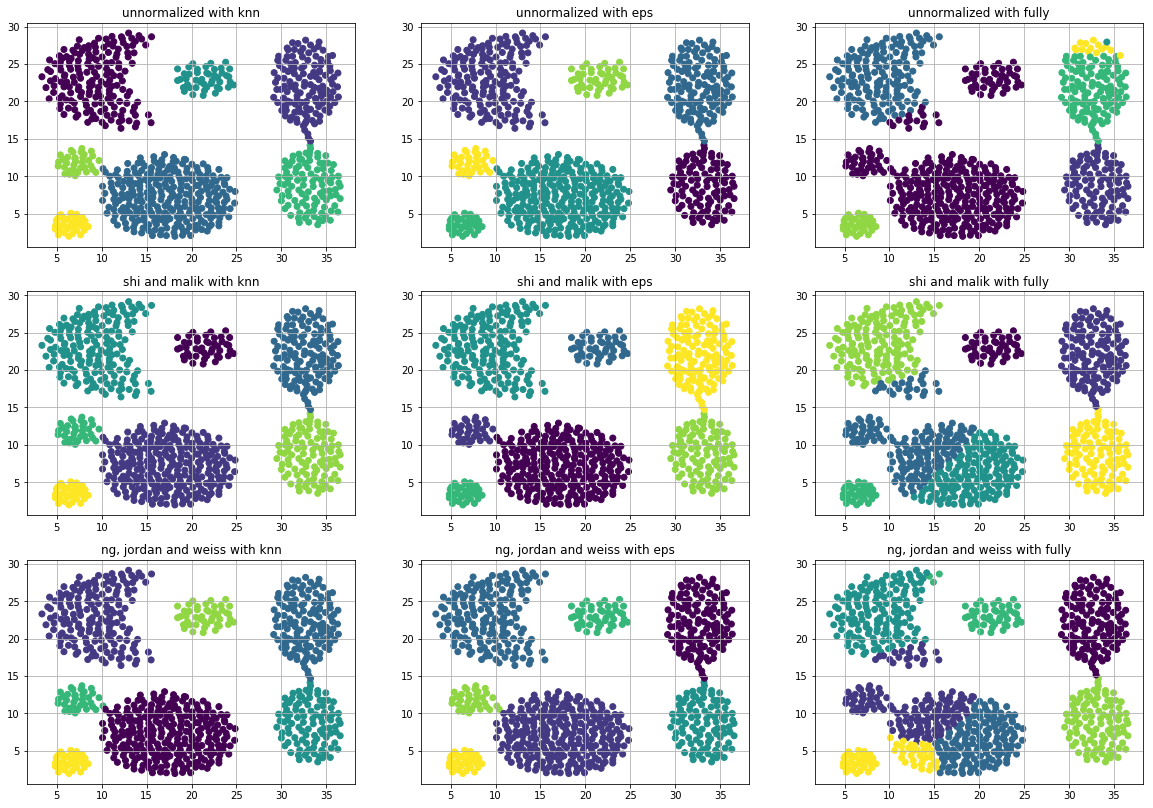

In [114]:
k = 7
eps = 0.80 
k_nn = 30 

results = []
experiments = [
    {'title':'unnormalized with knn','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'unnormalized with eps','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'unnormalized with fully','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'shi and malik with knn','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'shi and malik with eps','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'shi and malik with fully','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'ng, jordan and weiss with knn','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'ng, jordan and weiss with eps','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'ng, jordan and weiss with fully','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None}
]

matrix_similarity = euclidean_similarity(X.values)
for e in experiments:
    matrix_similarity_copy = matrix_similarity.copy()
    clusters = e['clusterization'](matrix_similarity_copy, e['k'], e['build_graph'], e['parameter_graph'])
    #avaliação númerica do resultado
    print(e['title']+" = "+str(adjusted_rand_score(Y.tolist(),clusters.tolist())))
    results.append({'x':x, 'y':y, 'c':clusters.tolist(), 'title': e['title']}),

#avaliação vizual do resultado
plot(results,3,3)

#### Gabarito

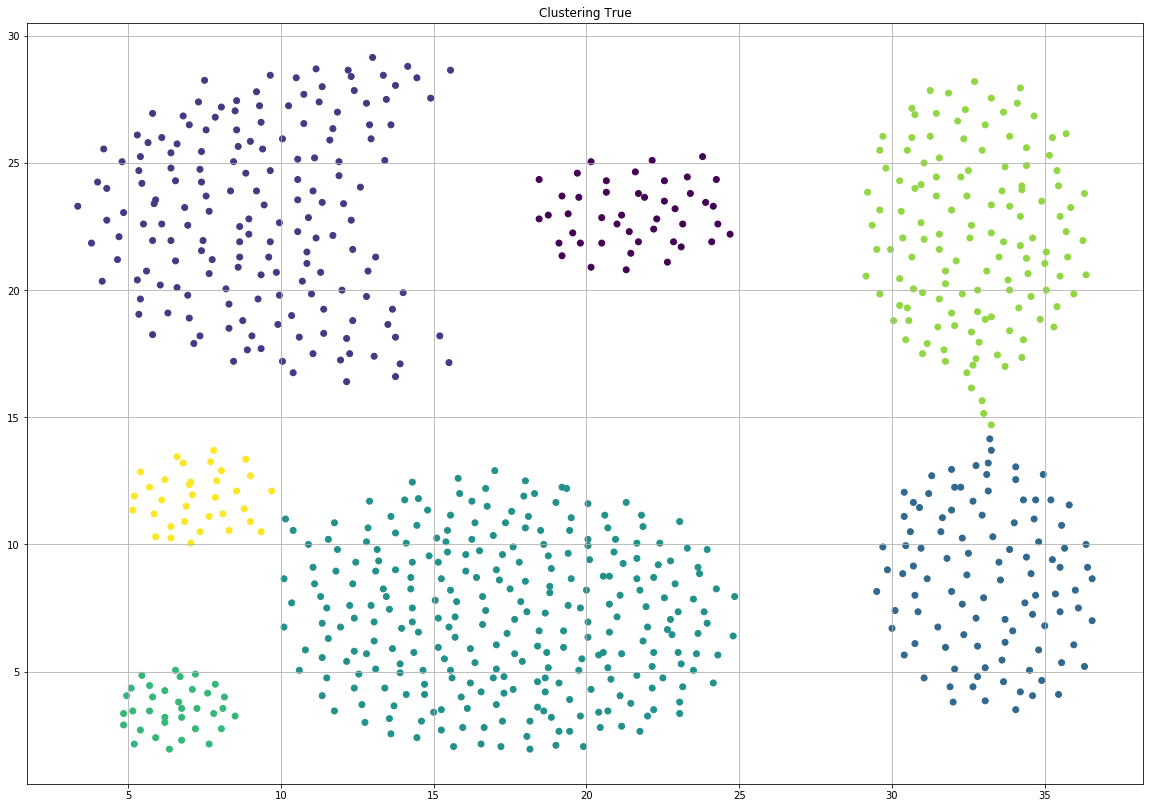

In [115]:
result_true = [
    {'x':x, 'y':y, 'c':Y.tolist(), 'title':'Clustering True'}
]
plot(result_true,1,1)

--------------------

#### Dataset Mopsi locations - User locations (Finland)

Este é um dataset composto por pontos em um plano cartesiano, que identifica a localização de usuários na Finlândia. Infelizmente este dataset não possue gabarito, por isso os parâmetros foram avaliados empiricamente. 

Pelos testes mostrados abaixo, os resultados foram razoáveis, considerando o coeficiente de sobreposição entre os clusters, que pode ser averigado pela Silhueta dos clusters, medida pelo módulo `silhouette_score`, disponível no pacote de métricas de clusterização do scikit-learn, em geral o coeficiente foi próximo de 0, o que indica a pouca sobreposição entre os clusters. Além disso, podemos destacar um contraste interessante em relação ao datasets anteriores, nestes dados, em alguns casos a estratégia `fully connected` se saiu melhor do que as outras como a `k-nearest neighboor`, considerando o coeficiente de silhueta, apesar de visualmente os algoritmos que usaram a estratégia `k-nearest neighboor` geraram clusters mais bem delineados.

**Disponível em: ** [http://cs.joensuu.fi/sipu/datasets/MopsiLocationsUntil2012-Finland.txt](http://cs.joensuu.fi/sipu/datasets/MopsiLocationsUntil2012-Finland.txt)

In [45]:
X = pd.read_csv('user_location/user_locations_Finland.csv',sep='\t')

x = X['x'].values.tolist()
y = X['y'].values.tolist()

euclidean_similarity - building matrix: 100%|██████████| 4360/4360 [03:03<00:00, 23.79it/s] 


silhueta de unnormalized with knn: -0.14021303986237596
silhueta de unnormalized with eps: -0.1611931173060005
silhueta de unnormalized with fully: -0.1611931173060005
silhueta de shi and malik with knn: -0.113267345347267
silhueta de shi and malik with eps: -0.10731527031810958
silhueta de shi and malik with fully: -0.10876951407377879
silhueta de ng, jordan and weiss with knn: -0.11245004333448859
silhueta de ng, jordan and weiss with eps: -0.10323948981733332
silhueta de ng, jordan and weiss with fully: -0.10415291215229114


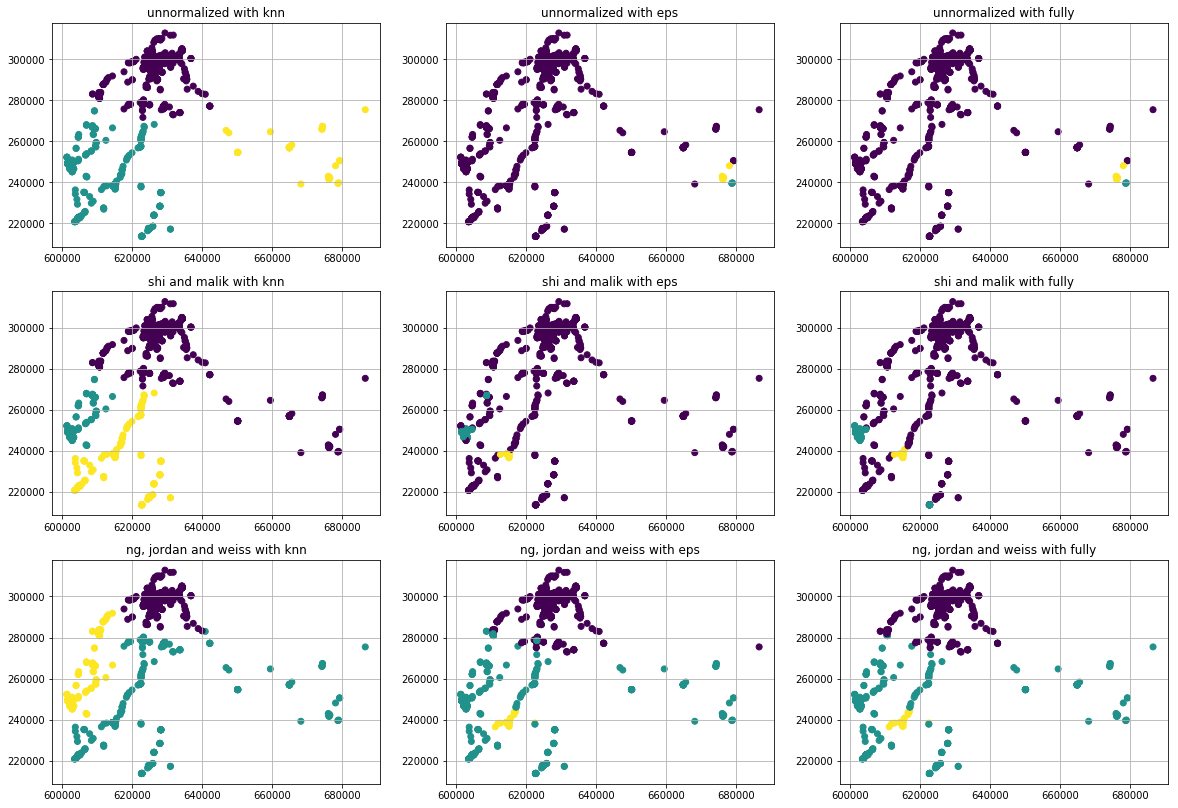

In [55]:
k = 3
eps = 1
k_nn = 20

results = []
experiments = [
    {'title':'unnormalized with knn','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'unnormalized with eps','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'unnormalized with fully','clusterization':unnormalized_spectral_clustering, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'shi and malik with knn','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'shi and malik with eps','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'shi and malik with fully','clusterization':normalized_spectral_clustering_shi_malik, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None},
    {'title':'ng, jordan and weiss with knn','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':k_nearest_neighbor, 'parameter_graph':k_nn},
    {'title':'ng, jordan and weiss with eps','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':eps_neighborhood, 'parameter_graph':eps},
    {'title':'ng, jordan and weiss with fully','clusterization':normalized_spectral_clustering_ng_jordan_weiss, 'k':k, 'build_graph':fully_connected, 'parameter_graph':None}
]

matrix_similarity = euclidean_similarity(X.values)
for e in experiments:
    matrix_similarity_copy = matrix_similarity.copy()
    clusters = e['clusterization'](matrix_similarity_copy, e['k'], e['build_graph'], e['parameter_graph'])
    print('silhueta de '+e['title']+': '+str(silhouette_score(matrix_similarity, clusters.tolist())))
    results.append({'x':x, 'y':y, 'c':clusters.tolist(), 'title': e['title']}),

#avaliação vizual do resultado
plot(results,3,3)

------------------------

## Referências

A. Gionis, H. Mannila, and P. Tsaparas, Clustering aggregation. ACM Transactions on Knowledge Discovery from Data (TKDD), 2007. 1(1): p. 1-30.

C.J. Veenman, M.J.T. Reinders, and E. Backer, A maximum variance cluster algorithm. IEEE Trans. Pattern Analysis and Machine Intelligence 2002. 24(9): p. 1273-1280.

Von Luxburg, Ulrike. "A tutorial on spectral clustering." Statistics and computing 17.4 (2007): 395-416.